# Q1) TOPIC MODELLING

### Getting data from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip *.zip

# Downloading NLTK Packages

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Importing Libraries

In [ ]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))

# Loading the dataset

In [ ]:
data=pd.read_csv('/content/Reviews.csv')

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## We are concerned with only the 'text' column, dropping the rest of columns

In [ ]:
data = data.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time','Summary'])
data.head(5)

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


# Preprocessing


## Checking for NA values

In [ ]:
data.isna().sum()

Text    0
dtype: int64

## Text Preprocessing
- Lowercasing
- Non-word character removal
- Removal of stopwords and words with length less than 3
- Lemmatizing

In [ ]:
def prepocessing(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)

    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word)>3]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = ' '.join(words)
    return cleaned_text

## Applying the preprocessing on 'Text' column

In [ ]:
data['Text'] = data['Text'].apply(prepocessing)

In [ ]:
data.head()

,Text
0,bought several vitality canned food product fo...
1,product arrived labeled jumbo salted peanutsth...
2,confection around century light pillowy citrus...
3,looking secret ingredient robitussin believe f...
4,great taffy great price wide assortment yummy ...


# **EDA**

### Number of characters apprearing in each sentence

<Axes: >

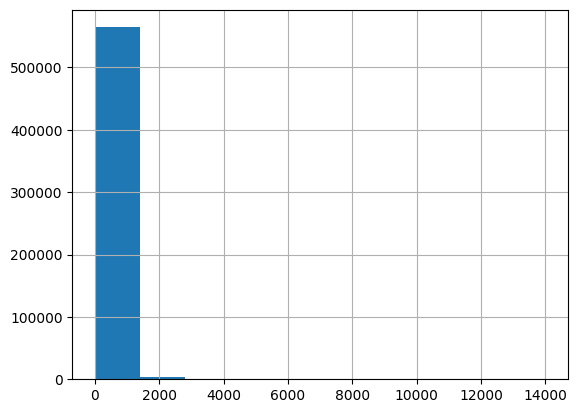

In [ ]:
data['Text'].str.len().hist()

### Hence, from the above chart it can be observed that almost all the reviews have the same length

## Checking the polarity scores of the reviews

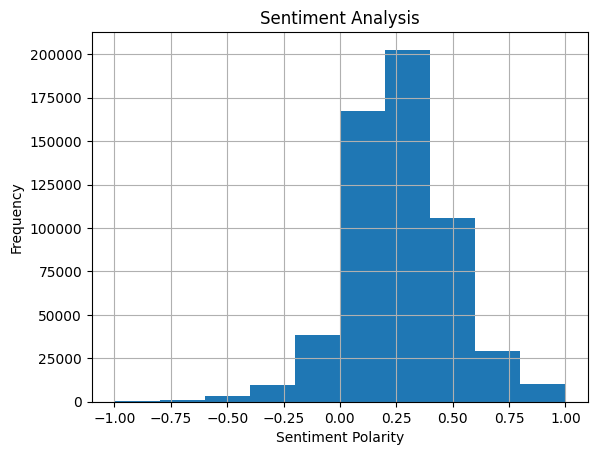

In [ ]:
from textblob import TextBlob
data['Sentiment'] = data['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['Sentiment'].hist()
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis')
plt.show()

## It can be observed from the above chart that majority of the reviews have a polarity score between 0 to 0.5
## Which indicates majority of the reviews are mildly positive reviews.

# Wordcloud

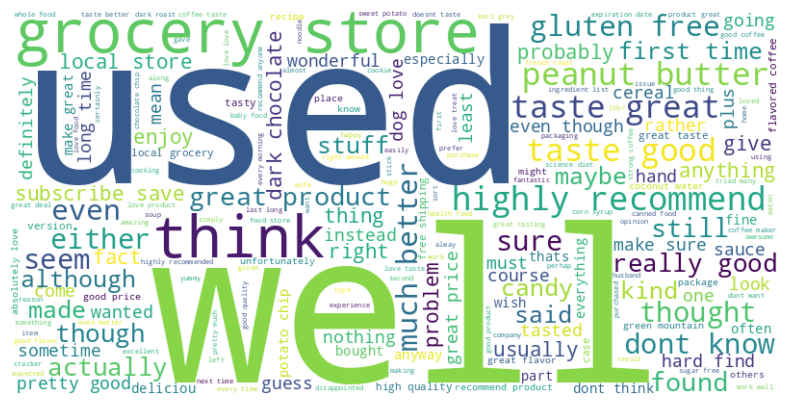

In [ ]:
combined = ' '.join(data['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Feature Extraction

## The Document-Term-Matrix is filled using TFidf values obtained by TfidfVectorizer


In [ ]:
vect =TfidfVectorizer(stop_words=list(stop_words),max_features=1000)

In [ ]:
vect_text=vect.fit_transform(data['Text'])

In [ ]:
print(vect_text.shape)

(568454, 1000)


In [ ]:
idf=vect.idf_

In [ ]:
names=dict(zip(vect.get_feature_names_out(), idf))
freq_occuring=sorted(names, key=(names).get)

## Top 10 most frequently occuring words based on the idf values obtained

In [ ]:
print(freq_occuring[:10])

['like', 'taste', 'good', 'love', 'great', 'flavor', 'product', 'would', 'make', 'really']


## 10 least frequently occuring words

In [ ]:
print(freq_occuring[-10:])

['jelly', 'wine', 'peppermint', 'tree', 'senseo', 'diamond', 'curry', 'shampoo', 'magnesium', 'matcha']


# **Models**


# 1) LSA

In [ ]:
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=10, random_state=42)    # n_iter = 10, since we want 10 topics

lsa_topic=lsa.fit_transform(vect_text)

In [ ]:
print(lsa_topic)
print(lsa_topic.shape)     #shape = (no.of records, topics)

[[ 0.26599876 -0.12901344  0.10754539 ...  0.0932977   0.08144324
   0.17049285]
 [ 0.15246359 -0.09154495 -0.00371294 ...  0.12949148 -0.00441561
   0.25017385]
 [ 0.10403244 -0.05921585  0.05514628 ...  0.01031863  0.01649392
   0.02692778]
 ...
 [ 0.26621713 -0.1613358   0.22779171 ... -0.00272212 -0.0121642
   0.08095874]
 [ 0.16168869 -0.08063525  0.0598318  ... -0.02214895  0.12748524
   0.03313627]
 [ 0.06482037 -0.04130052 -0.01684387 ...  0.04295525  0.00509218
   0.10595717]]
(568454, 10)


In [ ]:
l=lsa_topic[10]
print("Document 0 :")
for i,topic in enumerate(l):
  print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  19.163009059090296
Topic  1  :  -6.268067600420323
Topic  2  :  -2.280915385241805
Topic  3  :  -1.3309987023774232
Topic  4  :  1.0700820237289157
Topic  5  :  -0.8146135640887394
Topic  6  :  -1.3142272489415392
Topic  7  :  -7.638910943706034
Topic  8  :  -6.251496385526802
Topic  9  :  -5.309738928448566


#### For the 10th review (document), we can see that topic 0 is prominently present

## List of top 10 important words for each topic

In [ ]:
# Get the top words for each topic
terms = vect.get_feature_names()
topic_word_matrix = lsa.components_  #confirm if lsa or lsa_topic

# Print top 10 topics, words, and their probabilities
for i, topic in enumerate(topic_word_matrix):
    print(f"Topic {i + 1}:")
    top_words_idx = topic.argsort()[:-11:-1]  # Get indices of top 10 words
    top_words = [terms[idx] for idx in top_words_idx]
    top_probabilities = topic[top_words_idx]

    for word, prob in zip(top_words, top_probabilities):
        print(f"  Word: {word}, Probability: {prob:.4f}")
    print()

In [ ]:
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lsa.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
coffee like taste good great flavor love product food would 

Topic 1: 
coffee strong roast bold blend keurig kcups bitter kcup starbucks 

Topic 2: 
food coffee treat dog cat love year amazon chicken wellness 

Topic 3: 
product great price amazon store order find shipping love local 

Topic 4: 
treat love dog great snack training flavor chocolate chip chew 

Topic 5: 
chip food great flavor love snack chocolate best store price 

Topic 6: 
great product taste food love snack drink water healthy recommend 

Topic 7: 
chocolate product cooky food dark bar milk peanut coffee taste 

Topic 8: 
good chip price taste treat snack really like coffee potato 

Topic 9: 
product chip flavor salt would potato recommend chocolate coffee received 



# 2) Latent Dirichlet Allocation (LDA)  

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1)   # n_components = 10, since we want 10 topic

In [ ]:
lda_topic=lda.fit_transform(vect_text)

In [ ]:
print(lda_topic.shape)
print(lda_topic)

(568454, 10)
[[0.02202588 0.02202662 0.25193092 ... 0.0220218  0.02202998 0.51126386]
 [0.20125767 0.02908849 0.02909115 ... 0.02908127 0.20347485 0.3916673 ]
 [0.02276604 0.02276364 0.79514251 ... 0.02275421 0.02275749 0.02277291]
 ...
 [0.01838009 0.4349405  0.0183802  ... 0.01838073 0.01837689 0.36722621]
 [0.0239271  0.44321611 0.0239253  ... 0.02392045 0.02392806 0.21951412]
 [0.03163803 0.71535413 0.03162669 ... 0.03162406 0.0316279  0.0316269 ]]


### The sum would be 1 as LDA is a probabilistic model

In [ ]:
sum=0
for i in lda_topic[0]:
  sum=sum+i
print(sum)

1.0


In [ ]:
print("Document 0: ")
for i,topic in enumerate(lda_topic[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  2.2025880104830255 %
Topic  1 :  2.202661808893092 %
Topic  2 :  25.193092108432936 %
Topic  3 :  2.2025116954719812 %
Topic  4 :  2.2023407788246367 %
Topic  5 :  2.2027253366247925 %
Topic  6 :  8.262516041631098 %
Topic  7 :  2.2021799071690693 %
Topic  8 :  2.2029984784585035 %
Topic  9 :  51.12638583401087 %


## It can be observed above that document 0 consists prominently of topic 9

In [ ]:
print(lda.components_.shape)

(10, 1000)


## List of top 10 words for each topic

In [ ]:
vocab = vect.get_feature_names_out()

for i, comp in enumerate(lda.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
peanut drink butter taste flavor chocolate like love great wife 

Topic 1: 
chip taste like flavor good great snack salt love product 

Topic 2: 
product popcorn cooky would like good taste amazon gift bought 

Topic 3: 
oatmeal love chew training great bone pill oat easy jerky 

Topic 4: 
coffee kcups roast bold strong dark keurig bean bitter mountain 

Topic 5: 
coffee taste like flavor water good drink make blend tried 

Topic 6: 
candy canned thank party wellness sauce combination roll trip unique 

Topic 7: 
hair ball formula noodle newman diabetic shampoo cause office anywhere 

Topic 8: 
amazon price store find product order shipping great arrived local 

Topic 9: 
food treat dog love cat like product baby chicken month 



## Visualizing top 50 words for each topic using a **Wordcloud**

In [ ]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def draw_word_cloud(index):

  # Empty string to store important words for a topic
  imp_words_topic=""
  # Extracts the topic's components from the LDA model
  comp=lda.components_[index]
  # This line combines the vocabulary (list of words) with the corresponding component values for the specified topic
  vocab_comp = zip(vocab, comp)
  # Sorts in desc and selects top 50 words
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  # The following for loop iterates through the sorted words and appends them to the imp_words_topic string, separated by spaces
  for word in sorted_words:
      imp_words_topic=imp_words_topic+" "+word[0]
  #This line creates a WordCloud object with a specified width and height
  wordcloud = WordCloud(width=600, height=400).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

Wordcloud for topic 1:


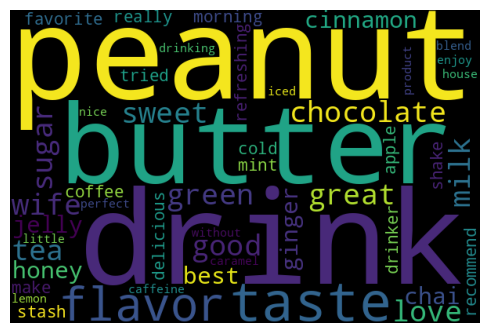

Wordcloud for topic 2:


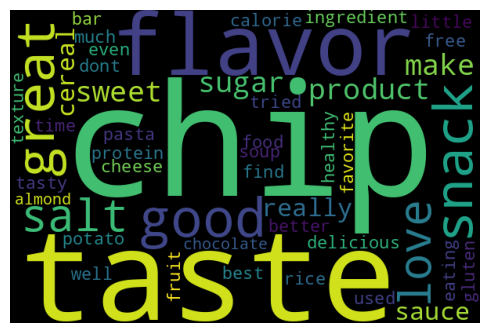

Wordcloud for topic 3:


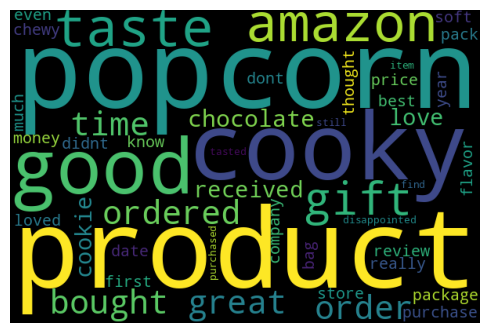

Wordcloud for topic 4:


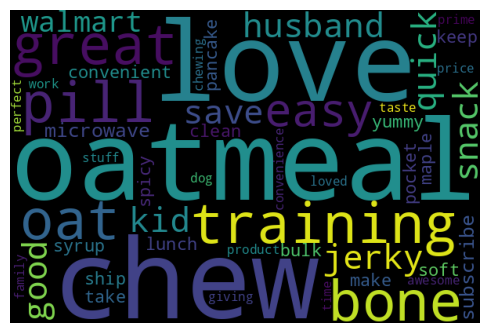

Wordcloud for topic 5:


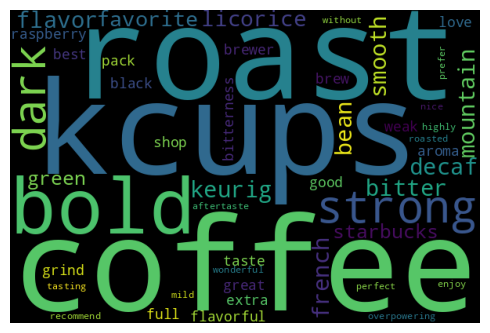

Wordcloud for topic 6:


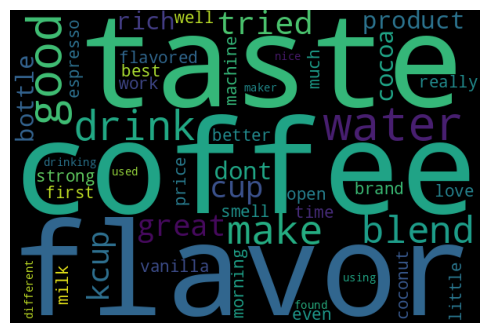

Wordcloud for topic 7:


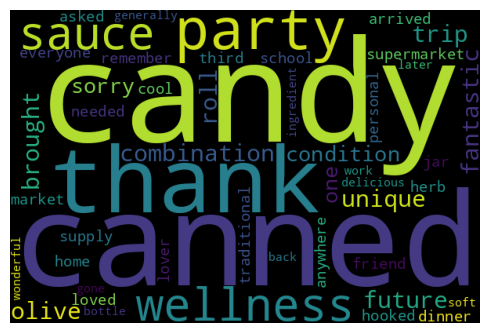

Wordcloud for topic 8:


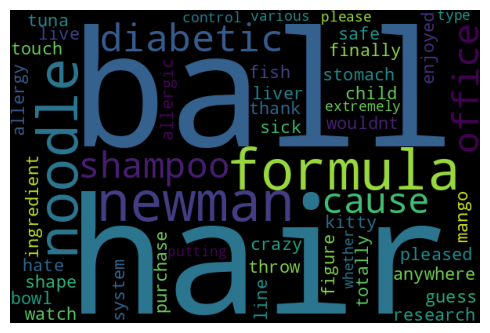

Wordcloud for topic 9:


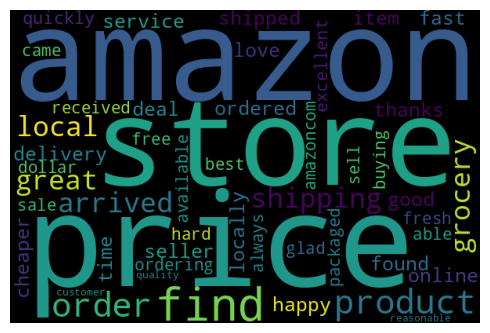

Wordcloud for topic 10:


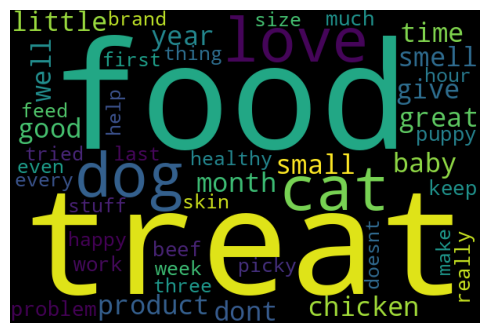

In [ ]:
num_topics = len(lda.components_)
for topic_index in range(num_topics):
  print(f"Wordcloud for topic {topic_index+1}:")
  draw_word_cloud(topic_index)